This notebook illustrates Linear Regression using Pseudo-Inverse and Outlier Rejection using Chebyshev's Inequality.

# Markov and Chebyshev's Inequality


In probability theory, __Markov's inequality__ gives an upper bound for the probability that a non-negative function of a random variable is greater than or equal to some positive constant.

Mathematically,

$$ P\{Y \geq a \} \leq \frac {E[Y]}{a} $$

Replacing, 
$$ a = \lambda^2 , \lambda > 0$$
$$ Y = \left(\frac {X-\mu}{\sigma}\right)^2$$

In probability theory, __Chebyshev's inequality__ guarantees that, for a wide class of probability distributions, no more than a certain fraction of values can be more than a certain distance from the mean. Specifically, no more than $1/\lambda^2$ of the distribution's values can be more than $\lambda$ standard deviations away from the mean (or equivalently, at least $1 − 1/\lambda^2$ of the distribution's values are within $\lambda$ standard deviations of the mean).

__Chebyshev's Inequality__,

$$ P\{|X-\mu| \geq \lambda\sigma \} \leq \frac{1}{\lambda^2}$$

Provides an Upper Bound on Membership for an
Instance based on its Distance from Mean
Normalized by Standard Deviation. No Properties of
the Underlying Distribution are Assumed.

One of the most important application of this Ineqaulity is in __Outlier Rejection__.

# Generate Dataset

Here we are generating $n$ number of points around the line $y = ax + b$. We will add some noise to get $y_{noisy}$ and then select a fraction of points from $y_{noisy}$ to further increase the intensity of noise to have $y_{noisy\_out}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
x = np.linspace(-5,5,100)
y = 3*x + 2            ## y = a*x + b
y_noisy = y + np.random.randn(100)

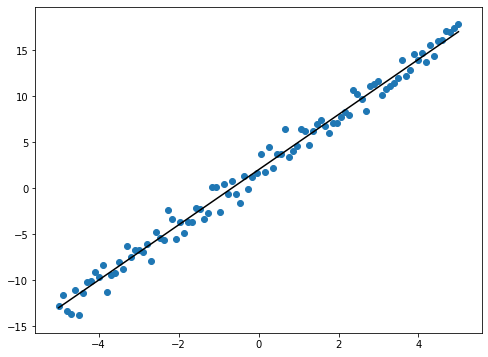

In [35]:
plt.figure(figsize=(8,6))
plt.plot(x,y,color='black')
plt.scatter(x,y_noisy)
plt.show()

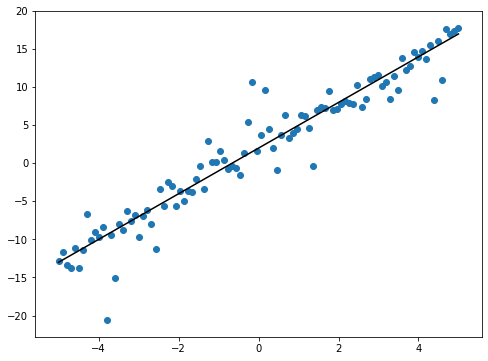

In [36]:
num = len(y_noisy)
alpha = 0.3
out_num = int(alpha*num)
selected = np.random.choice(num,out_num)
y_noisy_out = y_noisy.copy()
for i in range(num):
    if i in selected:
        y_noisy_out[i] = y[i] + 5*np.random.randn()
        
plt.figure(figsize=(8,6))
plt.plot(x,y,color='black')
plt.scatter(x,y_noisy_out)
plt.show()

In [7]:
xx = np.matrix(x).T
yy = np.matrix(y_noisy_out).T
one = np.ones((len(xx),1))
X = np.hstack((xx,one))
params = np.linalg.pinv(X).dot(yy)
params

matrix([[3.09896462],
        [1.94277862]])

In [8]:
a, b = params[0].item(), params[1].item()

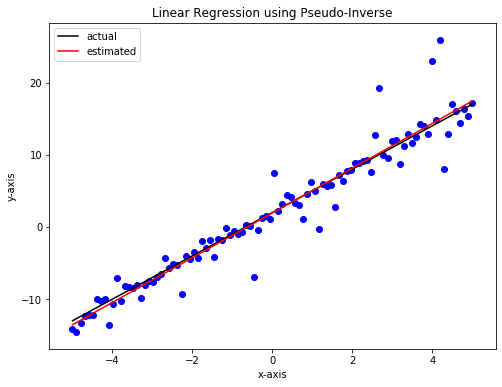

In [10]:
y_fit = a*x + b  #Best fitted line using pseudo-inverse

plt.figure(figsize=(8,6))
plt.plot(x,y,color='black',label='actual')
plt.plot(x,y_fit,color='red',label='estimated')
plt.scatter(x,y_noisy_out,color='blue')
plt.legend()
plt.title("Linear Regression using Pseudo-Inverse")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.show()

---
# Outlier Rejection

Implementation of two Outlier Rejection schemes namely Regression Diagonostic and RANSAC to get the best fit line on the data generated above. These algorithm uses Chebyshev's ineqality to get the outlier points.

## Regression Diagonostic

In [15]:
def regression_diagonostic(a,b,x,y,n_min,K,itrmax):
    
    for itr in range(itrmax):
        yg = a*x + b
        error = (y-yg)**2
        Emean = np.mean(error)
        Estd = np.std(error)
        eta = abs(Emean - K*Estd)
        
        xin = []
        yin = []
        xout = []
        yout = []
        
        for i in range(len(x)):
            if (error[i] < eta):
                xin.append(x[i])
                yin.append(y[i])
            else:
                xout.append(x[i])
                yout.append(y[i])
                
        if len(xin) <= n_min:
            print("Converged before completing all iterations!!!")
            print("iteration = ",itr+1)
            break
            
        ## Show Plots for each iteration
        plt.figure()
        plt.plot(x,yg,'black')
        plt.scatter(xin,yin,color='blue')
        plt.scatter(xout,yout,color='red')
        plt.show()
        
        x = np.array(xin)
        y = np.array(yin)
        
        xx = np.matrix(x).T
        yy = np.matrix(y).T
        one = np.ones((len(x),1))
        X = np.hstack((xx,one))
        params = np.linalg.pinv(X).dot(yy)
        a = params[0].item()
        b = params[1].item()
        print(f"a = {a}, b = {b}")
    return a,b

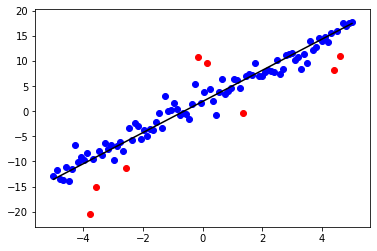

a = 2.9482629294263694, b = 2.107414948356202


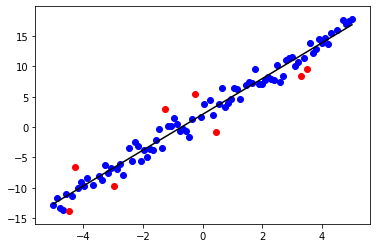

a = 2.9837181252524143, b = 2.146228963069698


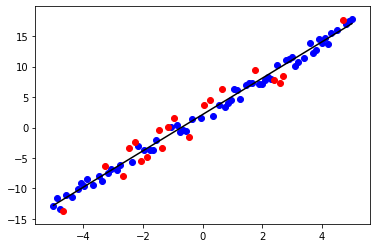

a = 2.9841680189794766, b = 2.0902406581745208
Converged before completing all iterations!!!
iteration =  4


In [52]:
a_best,b_best = regression_diagonostic(a,b,x,y_noisy_out,40,2,6)

## RANSAC

In [56]:
def RANSAC(itrmax, k, x, y_o):
    max_counter = 0
    for i in range(itrmax):
        print(f"Itr No:{i+1}")
        index = np.random.randint(0,len(x),2) #randomly select 2 points from given dataset

        if (x[index[1]] - x[index[0]]) == 0: #points x coordinate should not be same to avoid DIVIDE-BY-ZERO error
            continue

        slope = (y_o[index[1]] - y_o[index[0]]) / (x[index[1]] - x[index[0]]) #get slope
        intercept = y_o[index[1]] - slope*x[index[1]] #get intercept

        y_new = slope*x + intercept #get new line

        Error = (y_o - y_new)**2  #get error square
        mu = np.mean(Error) #get mean of error square
        std = np.std(Error) #get standard dev of error square

        counter = 0 #to store number of points satisfy chebyshev inequality(Inliers)
        #loop to count number of points satisfy chebyshev inequality
        x_in = []
        y_in = []
        x_out = []
        y_out = []
        for j in range(len(x)):
            if np.abs((Error[j]-mu)/std) < k:
                counter += 1
                x_in.append(x[j])
                y_in.append(y_o[j])
            else:
                x_out.append(x[j])
                y_out.append(y_o[j])
                
        if counter > max_counter:
            max_counter = counter
            best_slope = slope
            best_intercept = intercept
                
        #show plot of new line 
        plt.figure()
        plt.plot(x, y_new, c ='black')
        plt.scatter(x_in, y_in, c ='blue')
        plt.scatter(x_out, y_out, c ='red')
        plt.show()
        print(f"Number of Inliers: {counter}")

    return best_slope, best_intercept   

Itr No:1


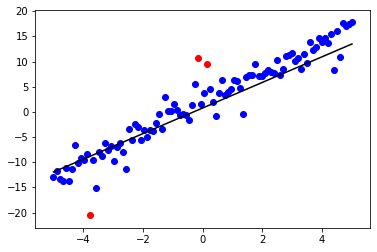

Number of Inliers: 97
Itr No:2


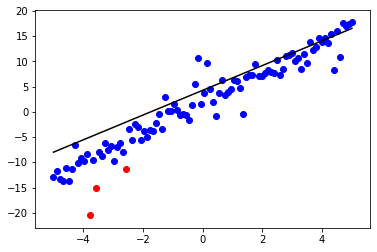

Number of Inliers: 97
Itr No:3


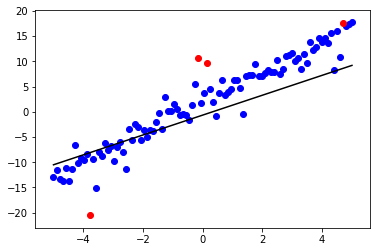

Number of Inliers: 96
Itr No:4


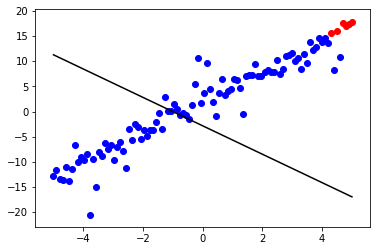

Number of Inliers: 94
Itr No:5


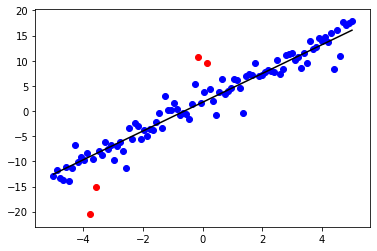

Number of Inliers: 96
Itr No:6


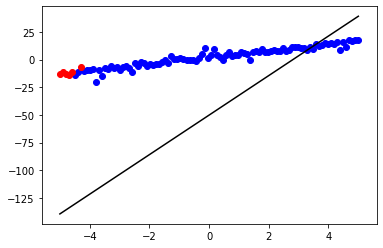

Number of Inliers: 94


In [64]:
best_slope, best_intercept = RANSAC(6, 2, x, y_noisy_out)

The equation of the line is: y = 2.5415044737384376*x + 0.7767091555866994


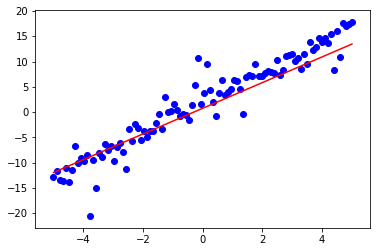

In [65]:
print(f"The equation of the line is: y = {best_slope}*x + {best_intercept}")
y_best = best_slope*x + best_intercept
plt.plot(x,y_best,c='red')
plt.scatter(x,y_noisy_out,c='blue')
plt.show()